In [1]:
from google.colab import files
import zipfile
import os
#uploaded = files.upload()
zip_filename = "archive.zip"
extract_path = "/content/dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(f"/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Extracted '{'archive.zip'}' to '{extract_path}'")


✅ Extracted 'archive.zip' to '/content/dataset'


In [2]:
# Upload and extract second dataset
#uploaded2 = files.upload()
from google.colab import files


import zipfile
import os
zip_filename2 = 'archive22.zip'

extract_path2 = "/content/dataset2"
os.makedirs(extract_path2, exist_ok=True)

with zipfile.ZipFile(f"/content/archive22.zip", 'r') as zip_ref2:
    zip_ref2.extractall(extract_path2)

print(f"✅ Extracted '{'archive22.zip'}' to '{extract_path2}'")


✅ Extracted 'archive22.zip' to '/content/dataset2'


In [3]:
import zipfile
import os

mat_folder = "/content/Figshare_MAT"
os.makedirs(mat_folder, exist_ok=True)

zip_paths = [
    "/content/dataset2/brainTumorDataPublic_1-766.zip",
    "/content/dataset2/brainTumorDataPublic_767-1532.zip",
    "/content/dataset2/brainTumorDataPublic_1533-2298.zip",
    "/content/dataset2/brainTumorDataPublic_2299-3064.zip"
]

for zip_file in zip_paths:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(mat_folder)

print(f" All .mat files extracted to {mat_folder}")


 All .mat files extracted to /content/Figshare_MAT


In [4]:
import os
import numpy as np
import cv2
from PIL import Image
import h5py
import scipy.io
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


In [5]:
import scipy.io
import h5py
import numpy as np
import os
import cv2
from PIL import Image

def convert_mat_to_image(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    label_map = {1: 'meningioma', 2: 'glioma', 3: 'pituitary'}
    count = 0

    for fname in os.listdir(input_folder):
        if not fname.endswith('.mat'):
            continue

        fpath = os.path.join(input_folder, fname)
        try:
            # Trying scipy
            mat = scipy.io.loadmat(fpath)
            cjdata = mat['cjdata'].item()
            image = cjdata['image']
            label = int(cjdata['label'][0][0])

        except NotImplementedError:
            try:
                with h5py.File(fpath, 'r') as f:
                    image = np.array(f['cjdata/image']).T
                    label = int(np.array(f['cjdata/label'])[0][0])
            except Exception as e:
                print(f"   Failed to read {fname} with h5py: {e}")
                continue
        except Exception as e:
            print(f" Failed to read {fname} with scipy: {e}")
            continue

        try:
            class_name = label_map[label]
            image_resized = cv2.resize(image, (227, 227))
            img_pil = Image.fromarray(image_resized).convert("RGB")

            class_folder = os.path.join(output_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)

            save_path = os.path.join(class_folder, fname.replace('.mat', '.jpg'))
            img_pil.save(save_path)
            count += 1
        except Exception as e:
            print(f" Conversion error for {fname}: {e}")

    print(f" Total converted images: {count}")

In [6]:
convert_mat_to_image("/content/Figshare_MAT", "/content/figshare_converted")

 Total converted images: 3064


In [7]:
import glob

for cls in ['glioma', 'meningioma', 'pituitary']:
    files = glob.glob(f"/content/figshare_converted/{cls}/*.jpg")
    print(f"{cls} → {len(files)} images")
import os
import shutil

def prepare_combined_dataset(kaggle_path, figshare_path):
    # Define unified class names
    kaggle_map = {
        'glioma_tumor': 'glioma',
        'meningioma_tumor': 'meningioma',
        'no_tumor': 'no_tumor',
        'pituitary_tumor': 'pituitary',

    }

    figshare_map = {
        'glioma': 'glioma',
        'meningioma': 'meningioma',
        'pituitary': 'pituitary',
    }

    combined_dir = "/content/combined"
    os.makedirs(combined_dir, exist_ok=True)

    # Create target class folders
    for cls in ['glioma', 'meningioma',   'no_tumor','pituitary']:
        os.makedirs(os.path.join(combined_dir, cls), exist_ok=True)

    # Copy from Kaggle
    for src_cls, target_cls in kaggle_map.items():
        src_path = os.path.join(kaggle_path, src_cls)
        if os.path.exists(src_path):
            for fname in os.listdir(src_path):
                src_file = os.path.join(src_path, fname)
                dst_file = os.path.join(combined_dir, target_cls, f"k_{fname}")
                if not os.path.exists(dst_file):
                    shutil.copy(src_file, dst_file)

    # Copy from Figshare
    for src_cls, target_cls in figshare_map.items():
        src_path = os.path.join(figshare_path, src_cls)
        if os.path.exists(src_path):
            for fname in os.listdir(src_path):
                src_file = os.path.join(src_path, fname)
                dst_file = os.path.join(combined_dir, target_cls, f"f_{fname}")
                if not os.path.exists(dst_file):
                    shutil.copy(src_file, dst_file)
prepare_combined_dataset("/content/dataset/Training", "/content/figshare_converted")
#train_gen, val_gen = create_generators("/content/combined")

print("✅ Combined dataset ready at /content/combined")



glioma → 1426 images
meningioma → 708 images
pituitary → 930 images
✅ Combined dataset ready at /content/combined


In [8]:
import os
import shutil
import glob

def prepare_combined_dataset(kaggle_path, figshare_path):
    # Actual class folders in Kaggle dataset (you may change this if needed)
    actual_kaggle_folders = os.listdir(kaggle_path)
    print("📂 Found Kaggle folders:", actual_kaggle_folders)

    # Flexible map based on actual folder names
    kaggle_map = {}
    for folder in actual_kaggle_folders:
        if "glioma" in folder.lower():
            kaggle_map[folder] = "glioma"
        elif "meningioma" in folder.lower():
            kaggle_map[folder] = "meningioma"
        elif "pituitary" in folder.lower():
            kaggle_map[folder] = "pituitary"
        elif "no" in folder.lower() or "notumor" in folder.lower():
            kaggle_map[folder] = "no_tumor"

    figshare_map = {
        'glioma': 'glioma',
        'meningioma': 'meningioma',
        'pituitary': 'pituitary',
    }

    combined_dir = "/content/combined"
    os.makedirs(combined_dir, exist_ok=True)

    # Create output class folders
    for cls in ['glioma', 'meningioma', 'pituitary', 'no_tumor']:
        os.makedirs(os.path.join(combined_dir, cls), exist_ok=True)

    print("\n✅ Copying from Kaggle dataset...")
    for src_cls, target_cls in kaggle_map.items():
        src_path = os.path.join(kaggle_path, src_cls)
        if os.path.exists(src_path):
            print(f"📥 Copying from: {src_cls} → {target_cls}")
            for fname in os.listdir(src_path):
                src_file = os.path.join(src_path, fname)
                dst_file = os.path.join(combined_dir, target_cls, f"k_{fname}")
                shutil.copy(src_file, dst_file)
        else:
            print(f"❌ Folder not found: {src_path}")

    print("\n✅ Copying from Figshare-converted dataset...")
    for src_cls, target_cls in figshare_map.items():
        src_path = os.path.join(figshare_path, src_cls)
        if os.path.exists(src_path):
            print(f"📥 Copying from: {src_cls} → {target_cls}")
            for fname in os.listdir(src_path):
                src_file = os.path.join(src_path, fname)
                dst_file = os.path.join(combined_dir, target_cls, f"f_{fname}")
                shutil.copy(src_file, dst_file)
        else:
            print(f"❌ Folder not found: {src_path}")

    print("\n✅ Combined dataset is ready at:", combined_dir)

    # Report total images per class
    for cls in ['glioma', 'meningioma', 'pituitary', 'no_tumor']:
        count = len(glob.glob(os.path.join(combined_dir, cls, '*.jpg')))
        print(f"{cls}: {count} images")

# Call the function
prepare_combined_dataset("/content/dataset/Training", "/content/figshare_converted")


📂 Found Kaggle folders: ['glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'no_tumor']

✅ Copying from Kaggle dataset...
📥 Copying from: glioma_tumor → glioma
📥 Copying from: pituitary_tumor → pituitary
📥 Copying from: meningioma_tumor → meningioma
📥 Copying from: no_tumor → no_tumor

✅ Copying from Figshare-converted dataset...
📥 Copying from: glioma → glioma
📥 Copying from: meningioma → meningioma
📥 Copying from: pituitary → pituitary

✅ Combined dataset is ready at: /content/combined
glioma: 2252 images
meningioma: 1530 images
pituitary: 1757 images
no_tumor: 395 images



📁 Fold 1
Found 3956 validated image filenames belonging to 4 classes.
Found 1978 validated image filenames belonging to 4 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 1074s 3s/step - accuracy: 0.5613 - loss: 1.0121 - val_accuracy: 0.7958 - val_loss: 0.5553
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 325ms/step - accuracy: 0.8313 - loss: 0.4419 - val_accuracy: 0.8979 - val_loss: 0.2467
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 327ms/step - accuracy: 0.8843 - loss: 0.2948 - val_accuracy: 0.8145 - val_loss: 0.5426
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 80s 324ms/step - accuracy: 0.9075 - loss: 0.2555 - val_accuracy: 0.8003 - val_loss: 0.5566
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 326ms/step - accuracy: 0.9140 - loss: 0.2324 - val_accuracy: 0.8468 - val_loss: 0.4723
124/124 ━━━━━━━━━━━━━━━━━━━━ 48s 230ms/step

✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.90      0.91       751
  meningioma       0.83      0.82      0.83       510
    no_tumor       0.95      0.92      0.93       132
   pituitary       0.92      0.96      0.94       585

    accur

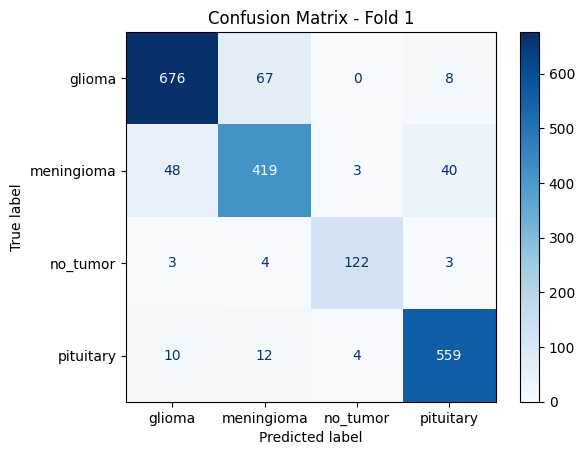

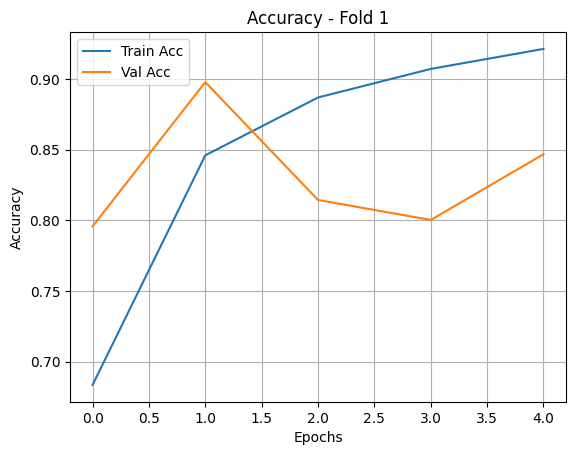


📁 Fold 2
Found 3956 validated image filenames belonging to 4 classes.
Found 1978 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 1054s 3s/step - accuracy: 0.5758 - loss: 1.0301 - val_accuracy: 0.8246 - val_loss: 0.4875
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 327ms/step - accuracy: 0.8170 - loss: 0.4678 - val_accuracy: 0.8807 - val_loss: 0.2825
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 80s 324ms/step - accuracy: 0.8790 - loss: 0.3273 - val_accuracy: 0.8807 - val_loss: 0.3017
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 335ms/step - accuracy: 0.8988 - loss: 0.2541 - val_accuracy: 0.8883 - val_loss: 0.2810
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 325ms/step - accuracy: 0.9124 - loss: 0.2271 - val_accuracy: 0.9191 - val_loss: 0.2007
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 219ms/step

✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.94      0.93       751
  meningioma       0.90      0.81      0.85       510
    no_tumor       0.99      0.93      0.96       131
   pituitary       0.92      0.98      0.95       586

    accur

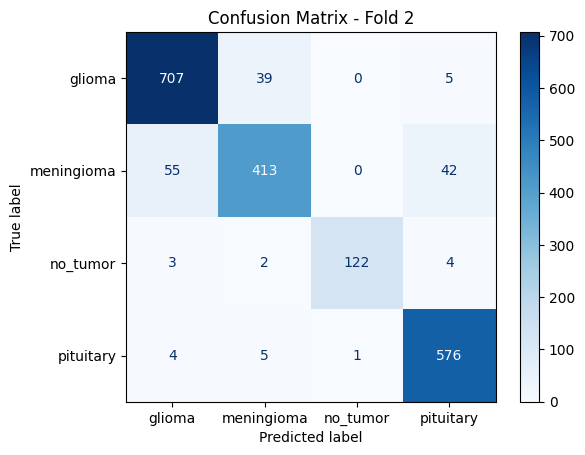

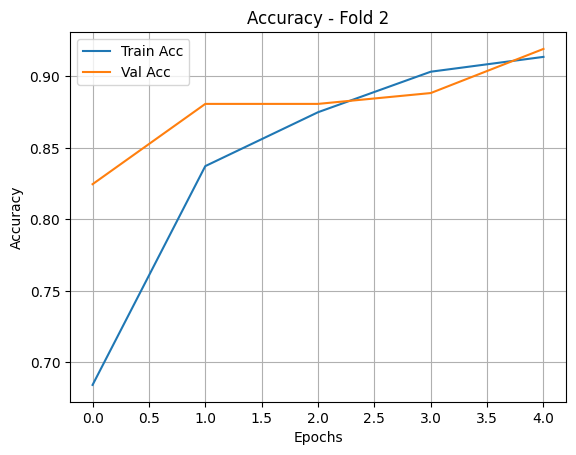


📁 Fold 3
Found 3956 validated image filenames belonging to 4 classes.
Found 1978 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 1111s 3s/step - accuracy: 0.5657 - loss: 1.0362 - val_accuracy: 0.7685 - val_loss: 0.5832
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 85s 341ms/step - accuracy: 0.8172 - loss: 0.4637 - val_accuracy: 0.8519 - val_loss: 0.4173
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 84s 339ms/step - accuracy: 0.8692 - loss: 0.3363 - val_accuracy: 0.8514 - val_loss: 0.3995
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 335ms/step - accuracy: 0.9086 - loss: 0.2448 - val_accuracy: 0.8610 - val_loss: 0.3584
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 84s 339ms/step - accuracy: 0.9132 - loss: 0.2303 - val_accuracy: 0.9009 - val_loss: 0.2460
124/124 ━━━━━━━━━━━━━━━━━━━━ 46s 223ms/step

✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.89      0.90       750
  meningioma       0.86      0.83      0.85       510
    no_tumor       0.96      0.96      0.96       132
   pituitary       0.90      0.97      0.93       586

    accur

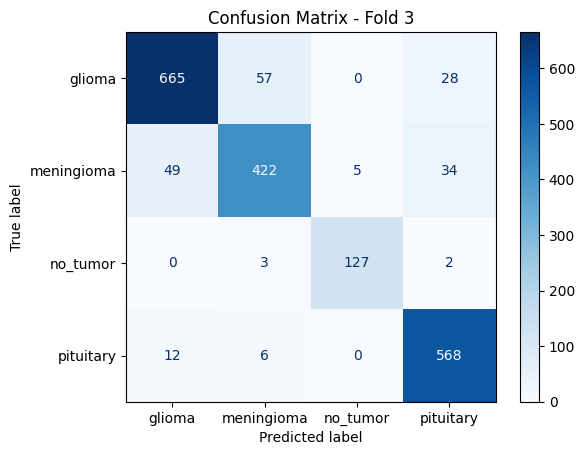

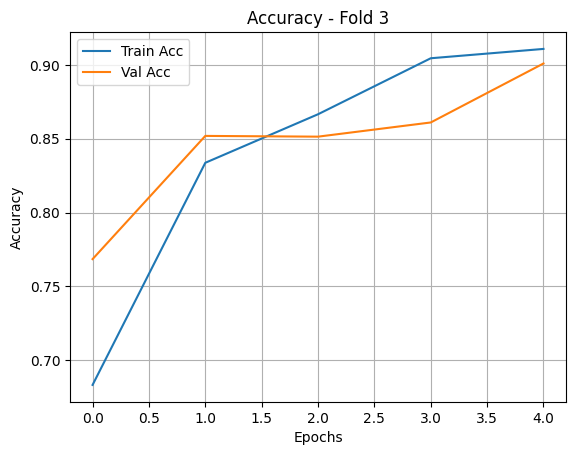

F1 Score (macro): 0.9104
F1 Score (weighted): 0.9002
Precision (macro): 0.9104
Recall (macro): 0.9114


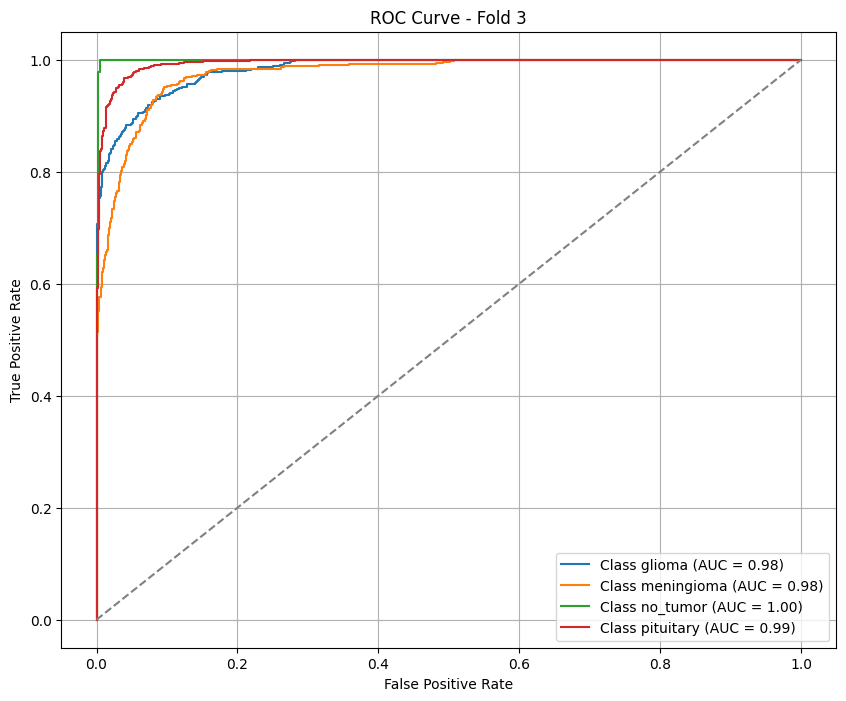

Macro-average AUC: 0.9880

📊 Final Accuracy Across 3 Folds: 90.60% ± 0.94


In [9]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, gc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input # Corrected import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Config
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 5
FOLDS = 3
DATA_PATH = "/content/combined"  # <- your combined Kaggle + Figshare dataset

# ✅ Step 1: Build DataFrame of all image paths and labels
def build_dataframe(data_dir):
    paths, labels = [], []
    for label in sorted(os.listdir(data_dir)):
        full_path = os.path.join(data_dir, label)
        if os.path.isdir(full_path):
            for fname in os.listdir(full_path):
                if fname.lower().endswith(('jpg', 'jpeg', 'png')):
                    paths.append(os.path.join(full_path, fname))
                    labels.append(label)
    return pd.DataFrame({'filename': paths, 'label': labels})

df = build_dataframe(DATA_PATH)
le = LabelEncoder()
df['encoded'] = le.fit_transform(df['label'])
class_names = le.classes_.tolist()
n_classes = len(class_names)

# ✅ Step 2: Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df['filename'], df['encoded'])):
    print(f"\n📁 Fold {fold+1}")
    train_df = df.iloc[train_idx].copy()
    val_df = df.iloc[val_idx].copy()

    # ✅ Data Generators with ImageNet-style preprocessing
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )
    val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_flow = train_gen.flow_from_dataframe(
        train_df, x_col='filename', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True
    )

    val_flow = val_gen.flow_from_dataframe(
        val_df, x_col='filename', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )

    # ✅ Build and compile the DenseNet201 model
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
    base_model.trainable = True  # 🔥 Enable full fine-tuning

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=out)

    model.compile(
        optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ✅ Train with EarlyStopping
    callbacks = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)]
    history = model.fit(train_flow, validation_data=val_flow, epochs=EPOCHS, callbacks=callbacks)

    # ✅ Evaluate
    val_preds = model.predict(val_flow)
    y_pred = np.argmax(val_preds, axis=1)
    y_true = val_flow.classes

    acc = accuracy_score(y_true, y_pred)
    accs.append(acc)

    print("\n✅ Classification Report:")
    print(classification_report(y_true, y_pred, target_names=val_flow.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=val_flow.class_indices.keys()).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.grid(False)
    plt.show()

    # ✅ Accuracy Plot
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy - Fold {fold+1}")
    plt.legend()
    plt.grid()
    plt.show()
    from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# ✅ Basic metrics
print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")

# ✅ ROC Curve - Multi-Class
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))  # shape: (n_samples, n_classes)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], val_preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve - Fold {fold+1}")
plt.legend(loc='lower right')
plt.grid()
plt.show()

# ✅ Optional: Average AUC score
macro_auc = roc_auc_score(y_true_bin, val_preds, average='macro')
print(f"Macro-average AUC: {macro_auc:.4f}")

del model, history
gc.collect()

# ✅ Final Result
print(f"\n📊 Final Accuracy Across {FOLDS} Folds: {np.mean(accs)*100:.2f}% ± {np.std(accs)*100:.2f}")


📁 Fold 1
Found 3956 validated image filenames belonging to 4 classes.
Found 1978 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5326 - loss: 1.0642 

248/248 ━━━━━━━━━━━━━━━━━━━━ 4896s 19s/step - accuracy: 0.5330 - loss: 1.0634 - val_accuracy: 0.7639 - val_loss: 0.5841
Epoch 2/3
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7914 - loss: 0.5356 

248/248 ━━━━━━━━━━━━━━━━━━━━ 4684s 19s/step - accuracy: 0.7914 - loss: 0.5355 - val_accuracy: 0.8716 - val_loss: 0.3211
Epoch 3/3
248/248 ━━━━━━━━━━━━━━━━━━━━ 4651s 19s/step - accuracy: 0.8510 - loss: 0.3773 - val_accuracy: 0.7846 - val_loss: 0.5548
124/124 ━━━━━━━━━━━━━━━━━━━━ 478s 4s/step

✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.82      0.95      0.88       751
  meningioma       0.91      0.65      0.76       510
    no_tumor       0.94      0.92      0.93       132
   pituitary       0.90      0.95      0.93       585

    accuracy                           0.87      1978
   macro avg       0.89      0.87      0.87      1978
weighted avg       0.88      0.87      0.87      1978



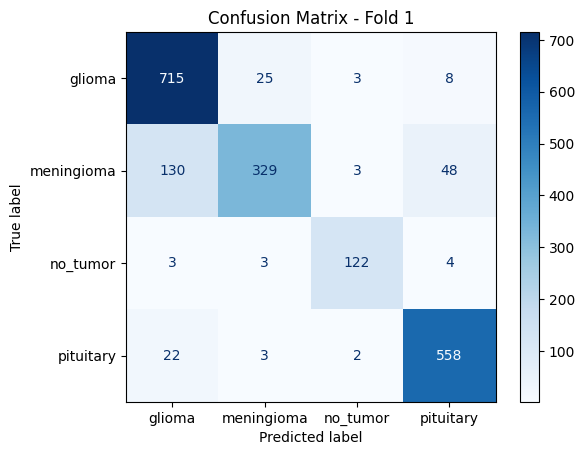

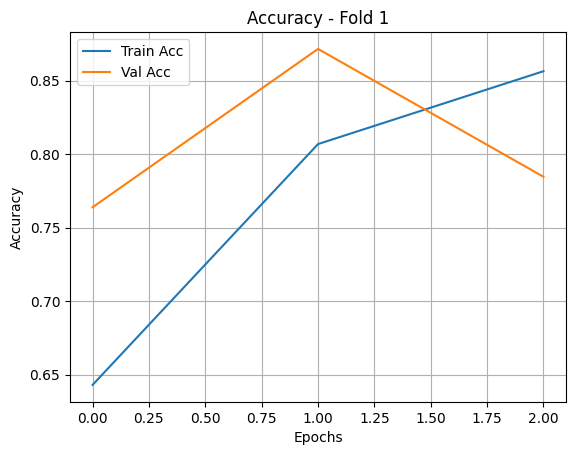


📁 Fold 2
Found 3956 validated image filenames belonging to 4 classes.
Found 1978 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3


In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, gc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.densenet import preprocess_input # Corrected import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201 # Uncommented DenseNet201 import

# ✅ CBAM Block
def cbam_block(x, reduction_ratio=8):
    # Channel Attention
    channel = x.shape[-1]
    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    max_pool = layers.GlobalMaxPooling2D()(x)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)

    shared_dense = models.Sequential([
        layers.Dense(channel // reduction_ratio, activation='relu'),
        layers.Dense(channel)
    ])

    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)
    channel_att = layers.Add()([avg_out, max_out])
    channel_att = layers.Activation('sigmoid')(channel_att)
    x = layers.Multiply()([x, channel_att])

    # Spatial Attention
    avg_pool = layers.Lambda(lambda z: tf.reduce_mean(z, axis=3, keepdims=True))(x)
    max_pool = layers.Lambda(lambda z: tf.reduce_max(z, axis=3, keepdims=True))(x)
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    spatial_att = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, spatial_att])

    return x


# ✅ Config
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 3
FOLDS = 3
DATA_PATH = "/content/combined"

# ✅ Build DataFrame
def build_dataframe(data_dir):
    paths, labels = [], []
    for label in sorted(os.listdir(data_dir)):
        full_path = os.path.join(data_dir, label)
        if os.path.isdir(full_path):
            for fname in os.listdir(full_path):
                if fname.lower().endswith(('jpg', 'jpeg', 'png')):
                    paths.append(os.path.join(full_path, fname))
                    labels.append(label)
    return pd.DataFrame({'filename': paths, 'label': labels})

df = build_dataframe(DATA_PATH)
le = LabelEncoder()
df['encoded'] = le.fit_transform(df['label'])
class_names = le.classes_.tolist()
n_classes = len(class_names)

# ✅ Stratified K-Fold
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df['filename'], df['encoded'])):
    print(f"\n📁 Fold {fold+1}")
    train_df = df.iloc[train_idx].copy()
    val_df = df.iloc[val_idx].copy()

    # ✅ Augmentations
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=25,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_flow = train_gen.flow_from_dataframe(
        train_df, x_col='filename', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True
    )

    val_flow = val_gen.flow_from_dataframe(
        val_df, x_col='filename', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )

    # ✅ Build Model
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
    base_model.trainable = True

    x = base_model.output
    x = cbam_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=out)
    model.compile(
        optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True),
        ModelCheckpoint(f"best_fold_{fold+1}.h5", monitor='val_accuracy', save_best_only=True)
    ]

    # ✅ Train
    history = model.fit(train_flow, validation_data=val_flow, epochs=EPOCHS, callbacks=callbacks)

    # ✅ Evaluate
    val_preds = model.predict(val_flow)
    y_pred = np.argmax(val_preds, axis=1)
    y_true = val_flow.classes

    acc = accuracy_score(y_true, y_pred)
    accs.append(acc)

    print("\n✅ Classification Report:")
    print(classification_report(y_true, y_pred, target_names=val_flow.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=val_flow.class_indices.keys()).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.grid(False)
    plt.show()

    # ✅ Accuracy Curve
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy - Fold {fold+1}")
    plt.legend()
    plt.grid()
    plt.show()

    del model, history
    gc.collect()

# ✅ Final Accuracy
print(f"\n📊 Final Accuracy Across {FOLDS} Folds: {np.mean(accs)*100:.2f}% ± {np.std(accs)*100:.2f}")

In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, gc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet201, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Config
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 15
FOLDS = 3
DATA_PATH = "/content/combined"  # <- your combined Kaggle + Figshare dataset

# ✅ Step 1: Build DataFrame of all image paths and labels
def build_dataframe(data_dir):
    paths, labels = [], []
    for label in sorted(os.listdir(data_dir)):
        full_path = os.path.join(data_dir, label)
        if os.path.isdir(full_path):
            for fname in os.listdir(full_path):
                if fname.lower().endswith(('jpg', 'jpeg', 'png')):
                    paths.append(os.path.join(full_path, fname))
                    labels.append(label)
    return pd.DataFrame({'filename': paths, 'label': labels})

df = build_dataframe(DATA_PATH)
le = LabelEncoder()
df['encoded'] = le.fit_transform(df['label'])
class_names = le.classes_.tolist()
n_classes = len(class_names)

# ✅ Step 2: Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df['filename'], df['encoded'])):
    print(f"\n📁 Fold {fold+1}")
    train_df = df.iloc[train_idx].copy()
    val_df = df.iloc[val_idx].copy()

    # ✅ Data Generators with ImageNet-style preprocessing
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )
    val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_flow = train_gen.flow_from_dataframe(
        train_df, x_col='filename', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True
    )

    val_flow = val_gen.flow_from_dataframe(
        val_df, x_col='filename', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )

    # ✅ Build and compile the DenseNet201 model
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
    base_model.trainable = True  # 🔥 Enable full fine-tuning

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=out)

    model.compile(
        optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ✅ Train with EarlyStopping
    callbacks = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)]
    history = model.fit(train_flow, validation_data=val_flow, epochs=EPOCHS, callbacks=callbacks)

    # ✅ Evaluate
    val_preds = model.predict(val_flow)
    y_pred = np.argmax(val_preds, axis=1)
    y_true = val_flow.classes

    acc = accuracy_score(y_true, y_pred)
    accs.append(acc)

    print("\n✅ Classification Report:")
    print(classification_report(y_true, y_pred, target_names=val_flow.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=val_flow.class_indices.keys()).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.grid(False)
    plt.show()

    # ✅ Accuracy Plot
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy - Fold {fold+1}")
    plt.legend()
    plt.grid()
    plt.show()

    del model, history
    gc.collect()

# ✅ Final Result
print(f"\n📊 Final Accuracy Across {FOLDS} Folds: {np.mean(accs)*100:.2f}% ± {np.std(accs)*100:.2f}")


ImportError: cannot import name 'preprocess_input' from 'tensorflow.keras.applications' (/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/applications/__init__.py)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
train_dir = '/content/combined'  # Where you merged Kaggle + Figshare classes
test_dir = '/content/combined'   # Same if you're splitting manually using validation_split


# Data Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Data
train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = train_dataset.classes

# Model: DenseNet201
model = models.densenet201(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(class_names))
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Function
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=5, target_accuracy=99.0):
    train_losses, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_accuracy = evaluate_model(model, test_loader, log=True)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        if val_accuracy >= target_accuracy:
            print(f"🎯 Target {target_accuracy}% reached.")
            break
    return train_losses, val_accuracies

# Evaluation Function
def evaluate_model(model, test_loader, log=True):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    if log:
        print(f"\nTest Accuracy: {accuracy:.2f}%")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        cm = confusion_matrix(all_labels, all_preds)
        ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues', values_format='d')
        plt.title("Confusion Matrix")
        plt.show()
    return accuracy

# Plot Metrics
def plot_metrics(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Training Loss'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.title('Validation Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

# Train
train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=40, target_accuracy=99.0)
plot_metrics(train_losses, val_accuracies)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Found 4748 images belonging to 4 classes.
Found 1186 images belonging to 4 classes.
Epoch 1/7
149/149 ━━━━━━━━━━━━━━━━━━━━ 841s 3s/step - accuracy: 0.6113 - loss: 0.9770 - val_accuracy: 0.7690 - val_loss: 0.5630
Epoch 2/7
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 602ms/step - accuracy: 0.8628 - loss: 0.3460 - val_accuracy: 0.8061 - val_loss: 0.4341
Epoch 3/7
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 600ms/step - accuracy: 0.9138 - loss: 0.2220 - val_accuracy: 0.7099 - val_loss: 0.9404
Epoch 4/7
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 603ms/step - accuracy: 0.9373 - loss: 0.1608 - val_accuracy: 0.7782 - val_loss: 0.5405
Epoch 5/7
149/149 ━━━━━━━━━━━━━━━━━━━━ 142s 603ms/step - accuracy: 0.9476 - loss: 0.1305 - val_accuracy: 0.8347 - val_loss: 0.5493
Epoch 6/7
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 597ms/step - accuracy: 0.9523 - loss: 0.1232 - val_accuracy: 0.8263 - val_loss: 0.5395
Epoch 7/7
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 605ms/step - accuracy: 0.9576 - loss: 0.1184 - val_accuracy: 0.7901 - val_loss: 0.7767
38/38 ━

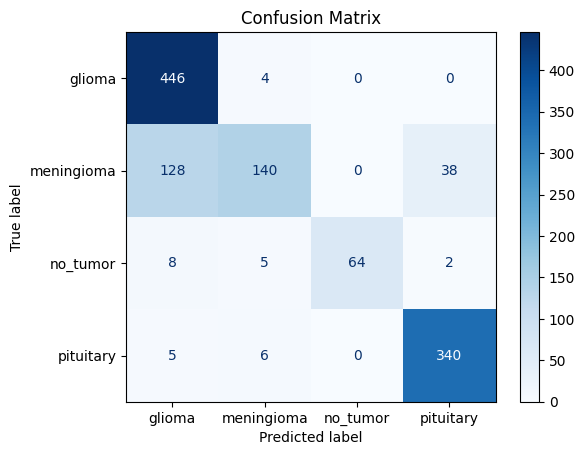

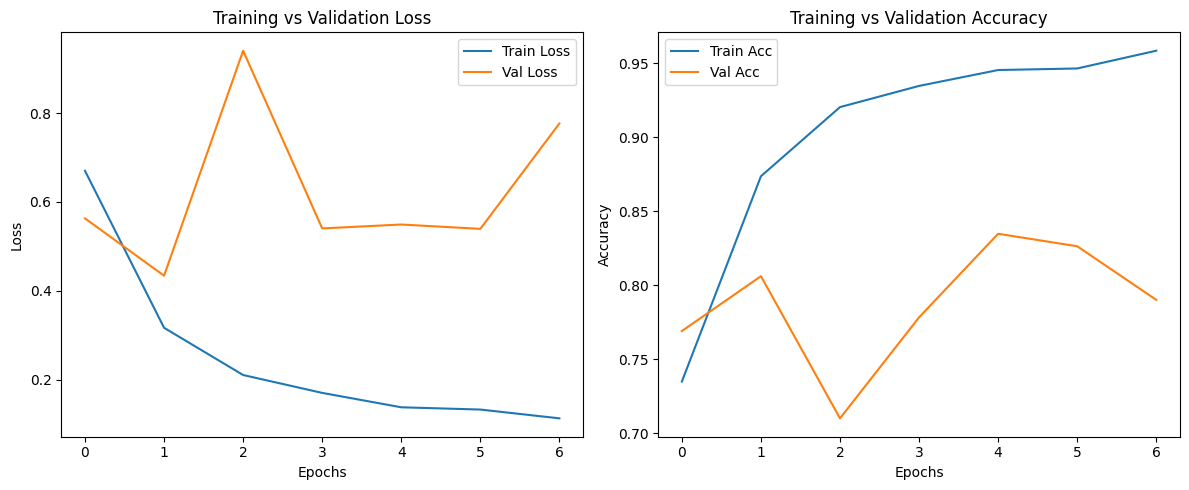

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Config
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 7
DATA_PATH = "/content/combined"

# ✅ 1. ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
n_classes = len(class_names)

# ✅ 2. Build DenseNet201 model
def build_densenet201_model(input_shape=(224,224,3), num_classes=4):
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # You can freeze some layers if needed

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=base_model.input, outputs=output)

model = build_densenet201_model(input_shape=(*IMG_SIZE, 3), num_classes=n_classes)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ 3. Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
]

# ✅ 4. Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ✅ 5. Evaluation
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

print(f"\nTest Accuracy: {np.mean(y_pred == y_true)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ✅ 6. Plot Training Curve
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history)



📁 Fold 1
Found 2967 validated image filenames belonging to 4 classes.
Found 2967 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 200s 696ms/step - accuracy: 0.5620 - loss: 0.9960 - val_accuracy: 0.8113 - val_loss: 0.4810
Epoch 2/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 56s 301ms/step - accuracy: 0.8058 - loss: 0.4972 - val_accuracy: 0.8328 - val_loss: 0.4257
Epoch 3/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 57s 307ms/step - accuracy: 0.8374 - loss: 0.4127 - val_accuracy: 0.8652 - val_loss: 0.3363
Epoch 4/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 56s 302ms/step - accuracy: 0.8744 - loss: 0.3214 - val_accuracy: 0.8622 - val_loss: 0.3733
Epoch 5/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 56s 299ms/step - accuracy: 0.9169 - loss: 0.2389 - val_accuracy: 0.8625 - val_loss: 0.3578
186/186 ━━━━━━━━━━━━━━━━━━━━ 56s 191ms/step

✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.81      0.97      0.88      1126
  meningioma       0.93      0.62      0.74       765
    no_tumor       0.95      0.87      0.91       198
   pituitary       0.89      0.94      0.92       878

    acc

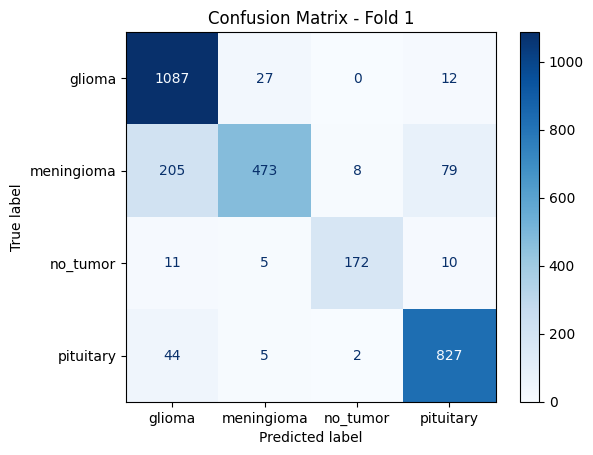

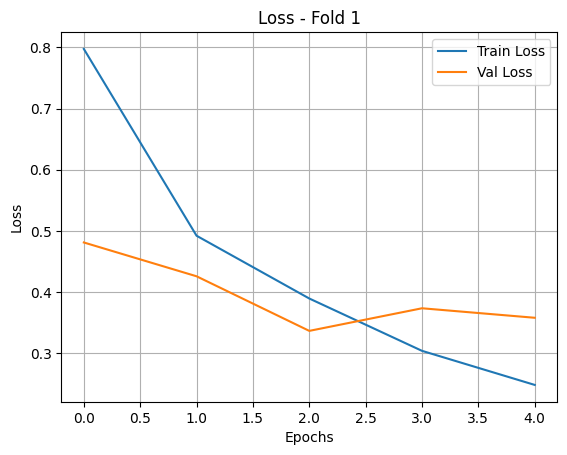


📁 Fold 2
Found 2967 validated image filenames belonging to 4 classes.
Found 2967 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 194s 669ms/step - accuracy: 0.5426 - loss: 1.0436 - val_accuracy: 0.7968 - val_loss: 0.4955
Epoch 2/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 59s 320ms/step - accuracy: 0.8041 - loss: 0.5086 - val_accuracy: 0.8335 - val_loss: 0.4076
Epoch 3/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 57s 308ms/step - accuracy: 0.8495 - loss: 0.3929 - val_accuracy: 0.8524 - val_loss: 0.3674
Epoch 4/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 57s 308ms/step - accuracy: 0.8722 - loss: 0.3260 - val_accuracy: 0.8713 - val_loss: 0.3062
Epoch 5/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 83s 316ms/step - accuracy: 0.8964 - loss: 0.2775 - val_accuracy: 0.8750 - val_loss: 0.3006
186/186 ━━━━━━━━━━━━━━━━━━━━ 55s 187ms/step

✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.89      0.88      0.89      1126
  meningioma       0.79      0.74      0.76       765
    no_tumor       0.90      0.91      0.91       197
   pituitary       0.91      0.98      0.94       879

    acc

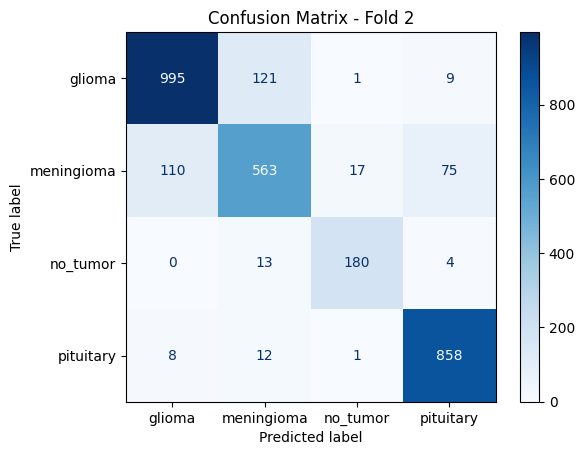

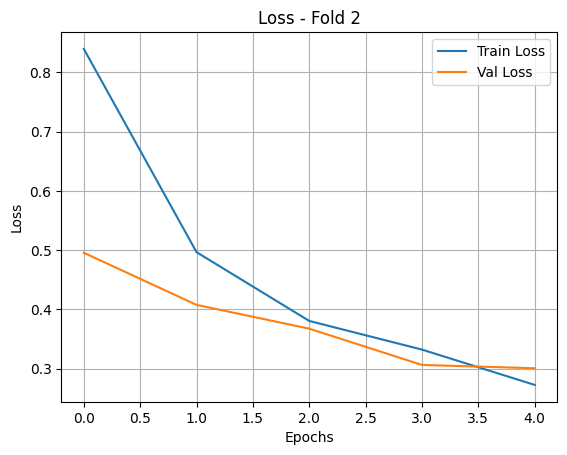


📊 Final Accuracy: 0.8687 ± 0.0062


In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, gc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Config
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 5
FOLDS = 2
DATA_PATH = "/content/combined"

# ✅ Step 1: Build DataFrame
def build_dataframe(data_dir):
    paths, labels = [], []
    for label in sorted(os.listdir(data_dir)):
        full_path = os.path.join(data_dir, label)
        if os.path.isdir(full_path):
            for fname in os.listdir(full_path):
                if fname.lower().endswith(('jpg', 'jpeg', 'png')):
                    paths.append(os.path.join(full_path, fname))
                    labels.append(label)
    return pd.DataFrame({'filename': paths, 'label': labels})

df = build_dataframe(DATA_PATH)
le = LabelEncoder()
df['encoded'] = le.fit_transform(df['label'])
class_names = le.classes_.tolist()
n_classes = len(class_names)

# ✅ Step 2: MCNN Block
def build_mcnn_block(input_tensor):
    p1 = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(input_tensor)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.MaxPooling2D((2, 2))(p1)
    p1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(p1)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.MaxPooling2D((2, 2))(p1)
    p1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.MaxPooling2D((2, 2))(p1)

    p2 = layers.Conv2D(4, (5, 5), activation='relu', padding='same')(input_tensor)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.MaxPooling2D((2, 2))(p2)
    p2 = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(p2)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.MaxPooling2D((2, 2))(p2)
    p2 = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(p2)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.MaxPooling2D((2, 2))(p2)

    merged = layers.Concatenate()([p1, p2])
    merged = layers.GlobalAveragePooling2D()(merged)
    return layers.Dense(256, activation='relu')(merged)

# ✅ Step 3: Full Hybrid Model
def build_hybrid_model():
    inp = layers.Input(shape=(*IMG_SIZE, 3))
    dnet = DenseNet201(include_top=False, weights='imagenet', input_tensor=inp, pooling='avg')
    for layer in dnet.layers[:-50]:
        layer.trainable = False
    dnet_feat = layers.Dense(256, activation='relu')(dnet.output)
    mcnn_feat = build_mcnn_block(inp)
    combined = layers.Concatenate(name='features')([dnet_feat, mcnn_feat])
    dropout = layers.Dropout(0.4)(combined)
    out = layers.Dense(n_classes, activation='softmax')(dropout)
    return models.Model(inputs=inp, outputs=out)

# ✅ Step 4: Train using StratifiedKFold and ImageDataGenerator
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df['filename'], df['encoded'])):
    print(f"\n📁 Fold {fold+1}")
    train_df = df.iloc[train_idx].copy()
    val_df = df.iloc[val_idx].copy()

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col='filename', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_dataframe(
        val_df, x_col='filename', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )

    model = build_hybrid_model()
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS, verbose=1)

    # Evaluation
    val_preds = model.predict(val_generator)
    y_pred = np.argmax(val_preds, axis=1)
    y_true = val_generator.classes

    acc = accuracy_score(y_true, y_pred)
    accs.append(acc)

    print("\n✅ Classification Report:")
    print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=val_generator.class_indices.keys()).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.grid(False)
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss - Fold {fold+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    del model, history
    gc.collect()

print(f"\n📊 Final Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")



📁 Fold 1
Epoch 1/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 163s 999ms/step - accuracy: 0.5810 - loss: 1.2438 - val_accuracy: 0.8116 - val_loss: 0.5278
Epoch 2/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.8839 - loss: 0.2945 - val_accuracy: 0.8709 - val_loss: 0.3518
Epoch 3/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - accuracy: 0.9340 - loss: 0.1805 - val_accuracy: 0.8969 - val_loss: 0.2736
Epoch 4/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.9576 - loss: 0.1241 - val_accuracy: 0.9006 - val_loss: 0.2515
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 323ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step

✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.93      0.92      1126
  meningioma       0.87      0.80      0.83       765
    no_tumor       0.96      0.89      0.92       198
   pituitary       0.94      0.99      0.96       878

    accuracy                           0.91      2967
   macro avg       0.92      0.90      0.91

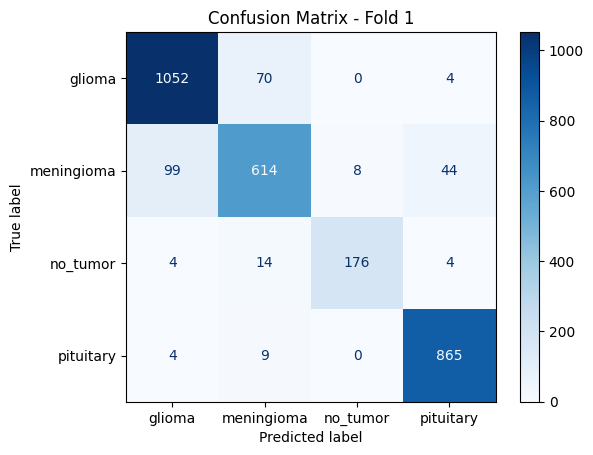

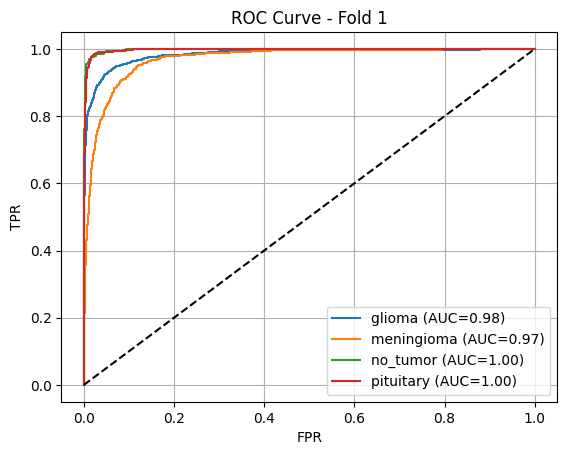

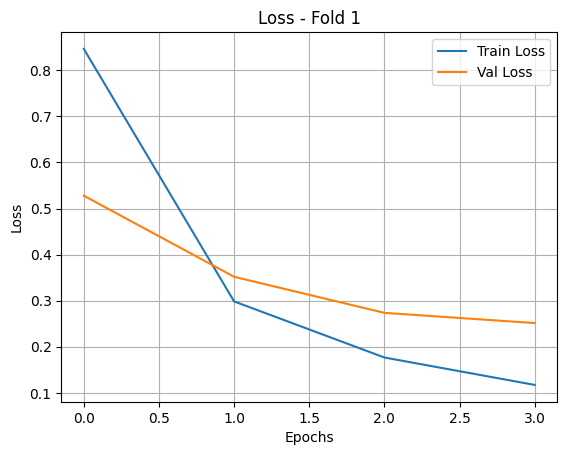


📁 Fold 2
Epoch 1/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 149s 959ms/step - accuracy: 0.6352 - loss: 1.0790 - val_accuracy: 0.7877 - val_loss: 0.5441
Epoch 2/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.8860 - loss: 0.2867 - val_accuracy: 0.8440 - val_loss: 0.3643
Epoch 3/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.9348 - loss: 0.1772 - val_accuracy: 0.8834 - val_loss: 0.3000
Epoch 4/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.9693 - loss: 0.0956 - val_accuracy: 0.9110 - val_loss: 0.2356
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 270ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step

✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.91      0.92      1126
  meningioma       0.83      0.85      0.84       765
    no_tumor       0.90      0.87      0.88       197
   pituitary       0.95      0.97      0.96       879

    accuracy                           0.91      2967
   macro avg       0.90      0.90      0.90

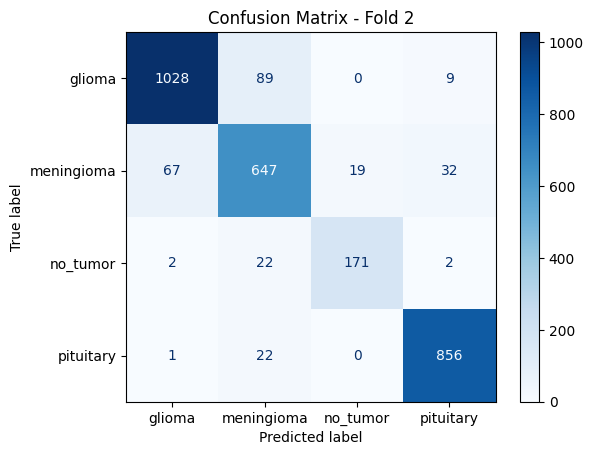

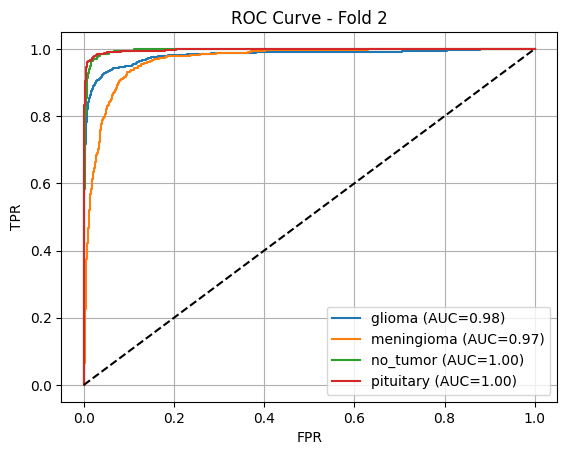

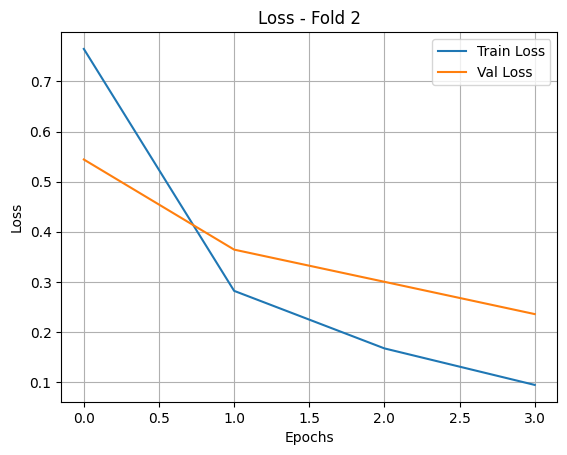


📊 Final Accuracy: 0.9115 ± 0.0008


In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, gc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.svm import SVC
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# ✅ Config
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 4
FOLDS = 2
DATA_PATH = "/content/combined"

# ✅ Step 1: Build DataFrame
def build_dataframe(data_dir):
    paths, labels = [], []
    for label in sorted(os.listdir(data_dir)):
        full_path = os.path.join(data_dir, label)
        if os.path.isdir(full_path):
            for fname in os.listdir(full_path):
                if fname.lower().endswith(('jpg', 'jpeg', 'png')):
                    paths.append(os.path.join(full_path, fname))
                    labels.append(label)
    return pd.DataFrame({'filename': paths, 'label': labels})

df = build_dataframe(DATA_PATH)
le = LabelEncoder()
df['encoded'] = le.fit_transform(df['label'])
class_names = le.classes_.tolist()
n_classes = len(class_names)
labels = list(range(n_classes))

# ✅ Step 2: Load images manually
def load_images(paths):
    images = []
    for p in paths:
        try:
            img = load_img(p, target_size=IMG_SIZE)
            img = img_to_array(img)
            img = preprocess_input(img)
            images.append(img)
        except:
            continue
    return np.array(images)

# ✅ Step 3: MCNN block
def build_mcnn_block(input_tensor):
    p1 = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(input_tensor)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.MaxPooling2D((2, 2))(p1)
    p1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(p1)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.MaxPooling2D((2, 2))(p1)
    p1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.MaxPooling2D((2, 2))(p1)

    p2 = layers.Conv2D(4, (5, 5), activation='relu', padding='same')(input_tensor)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.MaxPooling2D((2, 2))(p2)
    p2 = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(p2)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.MaxPooling2D((2, 2))(p2)
    p2 = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(p2)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.MaxPooling2D((2, 2))(p2)

    # Merge
    merged = layers.Concatenate()([p1, p2])
    merged = layers.Flatten()(merged)
    return layers.Dense(256, activation='relu')(merged)

# ✅ Step 4: Hybrid model
def build_hybrid_model():
    inp = layers.Input(shape=(*IMG_SIZE, 3))
    dnet = DenseNet201(include_top=False, weights='imagenet', input_tensor=inp, pooling='avg')
    for layer in dnet.layers[:-50]:
        layer.trainable = False
    dnet_feat = layers.Dense(256, activation='relu')(dnet.output)
    mcnn_feat = build_mcnn_block(inp)
    combined = layers.Concatenate(name='features')([dnet_feat, mcnn_feat])
    dropout = layers.Dropout(0.4)(combined)
    out = layers.Dense(n_classes, activation='softmax')(dropout)
    return models.Model(inputs=inp, outputs=out)

# ✅ Step 5: StratifiedKFold + Training
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df['filename'], df['encoded'])):
    print(f"\n📁 Fold {fold+1}")

    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    X_train = load_images(train_df['filename'].values)
    X_val = load_images(val_df['filename'].values)
    y_train = to_categorical(train_df['encoded'], num_classes=n_classes)
    y_val_cat = to_categorical(val_df['encoded'], num_classes=n_classes)
    y_val = val_df['encoded'].values

    model = build_hybrid_model()
    model.compile(optimizer=optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val_cat), epochs=EPOCHS, verbose=1)

    feat_model = models.Model(inputs=model.input, outputs=model.get_layer('features').output)
    train_feats = feat_model.predict(X_train, verbose=1)
    val_feats = feat_model.predict(X_val, verbose=1)

    clf = SVC(kernel='linear', probability=True)
    clf.fit(train_feats, train_df['encoded'])
    y_pred = clf.predict(val_feats)
    y_proba = clf.predict_proba(val_feats)

    acc = accuracy_score(y_val, y_pred)
    accs.append(acc)

    print("\n✅ Classification Report:")
    print(classification_report(y_val, y_pred, target_names=class_names))

    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.grid(False)
    plt.show()

    y_val_bin = label_binarize(y_val, classes=range(n_classes))
    for i in range(n_classes):
        if np.sum(y_val_bin[:, i]) == 0:
            print(f"⚠️ Skipping class '{class_names[i]}' in ROC (not in val)")
            continue
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={auc(fpr, tpr):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - Fold {fold+1}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss - Fold {fold+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    del model, feat_model, train_feats, val_feats, X_train, X_val
    gc.collect()

print(f"\n📊 Final Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")



📁 Fold 1


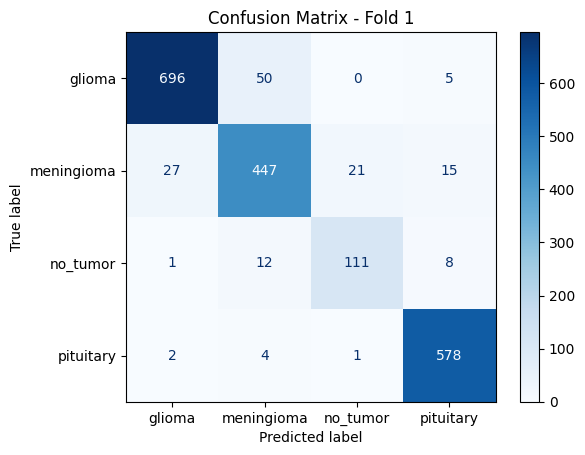

              precision    recall  f1-score   support

      glioma       0.96      0.93      0.94       751
  meningioma       0.87      0.88      0.87       510
    no_tumor       0.83      0.84      0.84       132
   pituitary       0.95      0.99      0.97       585

    accuracy                           0.93      1978
   macro avg       0.90      0.91      0.91      1978
weighted avg       0.93      0.93      0.93      1978



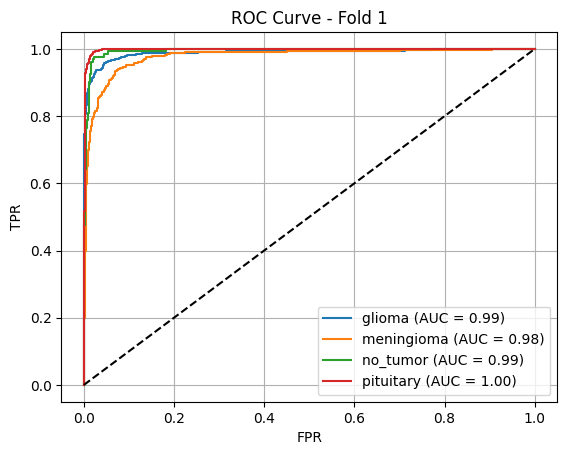


📁 Fold 2


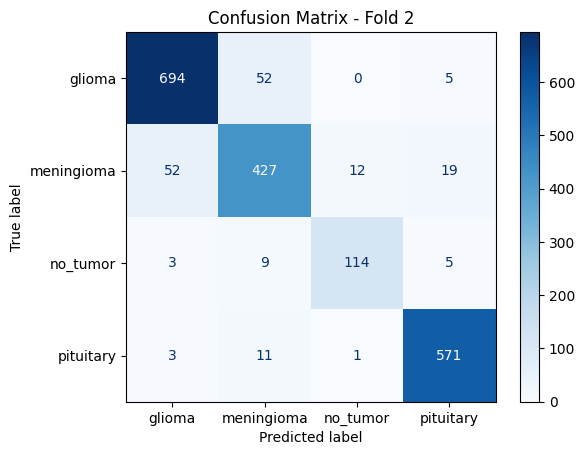

              precision    recall  f1-score   support

      glioma       0.92      0.92      0.92       751
  meningioma       0.86      0.84      0.85       510
    no_tumor       0.90      0.87      0.88       131
   pituitary       0.95      0.97      0.96       586

    accuracy                           0.91      1978
   macro avg       0.91      0.90      0.90      1978
weighted avg       0.91      0.91      0.91      1978



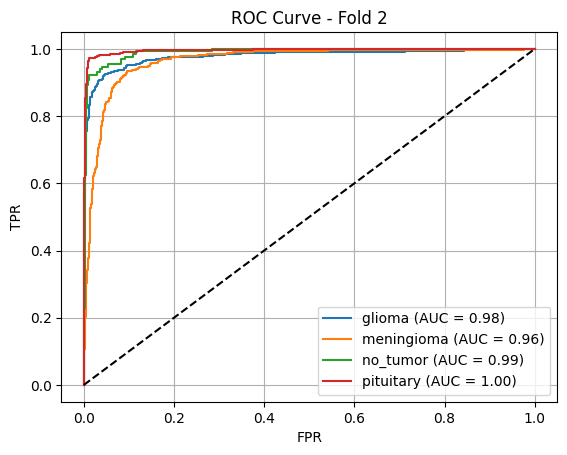


📁 Fold 3


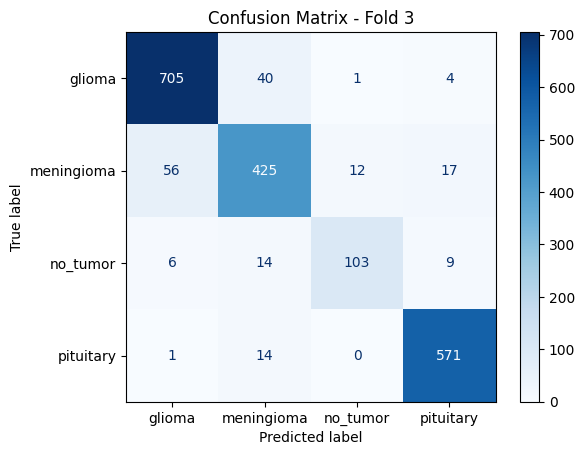

              precision    recall  f1-score   support

      glioma       0.92      0.94      0.93       750
  meningioma       0.86      0.83      0.85       510
    no_tumor       0.89      0.78      0.83       132
   pituitary       0.95      0.97      0.96       586

    accuracy                           0.91      1978
   macro avg       0.90      0.88      0.89      1978
weighted avg       0.91      0.91      0.91      1978



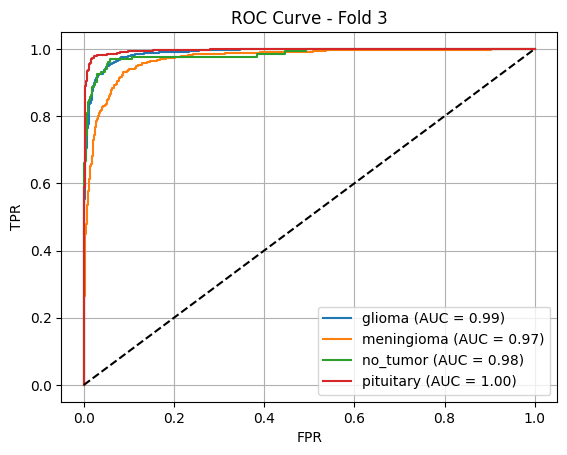


📊 Mean Accuracy: 0.9171 ± 0.0064


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import os, numpy as np, gc
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc
)


IMG_SIZE = (227, 227)
BATCH_SIZE = 12
EPOCHS = 5
FOLDS = 3

common_classes = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
rename_map_kaggle = {
    'glioma_tumor': 'glioma',
    'meningioma_tumor': 'meningioma',
    'pituitary_tumor': 'pituitary',
    'no_tumor': 'no_tumor'
}
rename_map_figshare = {
    'glioma': 'glioma',
    'meningioma': 'meningioma',
    'pituitary': 'pituitary'
}
#paths and labels
def get_image_paths_and_labels(folder, rename_map, keep_classes):
    paths, labels = [], []
    for folder_name in sorted(os.listdir(folder)):
        key = folder_name.strip().lower()
        if key in rename_map:
            cls = rename_map[key]
            if cls in keep_classes:
                for f in os.listdir(os.path.join(folder, folder_name)):
                    paths.append(os.path.join(folder, folder_name, f))
                    labels.append(cls)
    return np.array(paths), np.array(labels)

def load_images(paths):
    images = []
    for p in paths:
        try:
            img = load_img(p, target_size=IMG_SIZE)
            img = img_to_array(img) / 255.0
            images.append(img)
        except:
            continue
    return np.array(images)

def build_mcnn33_model(n_classes):
    input_layer = layers.Input(shape=(227, 227, 3))

    p1 = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(input_layer)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.MaxPooling2D((2, 2))(p1)
    p1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(p1)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.MaxPooling2D((2, 2))(p1)
    p1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    p1 = layers.BatchNormalization()(p1)
    p1 = layers.MaxPooling2D((2, 2))(p1)

    p2 = layers.Conv2D(4, (5, 5), activation='relu', padding='same')(input_layer)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.MaxPooling2D((2, 2))(p2)
    p2 = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(p2)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.MaxPooling2D((2, 2))(p2)
    p2 = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(p2)
    p2 = layers.BatchNormalization()(p2)
    p2 = layers.MaxPooling2D((2, 2))(p2)

    merged = layers.Concatenate()([p1, p2])
    merged = layers.Flatten()(merged)
    fc = layers.Dense(512, activation='relu', name='feature_layer')(merged)
    output = layers.Dense(n_classes, activation='softmax')(fc)

    return models.Model(inputs=input_layer, outputs=output)

def extract_features(model, X):
    extractor = models.Model(inputs=model.input, outputs=model.get_layer('feature_layer').output)
    return extractor.predict(X, verbose=0)

X1_paths, y1 = get_image_paths_and_labels("/content/dataset/Training", rename_map_kaggle, common_classes)
X2_paths, y2 = get_image_paths_and_labels("/content/figshare_converted", rename_map_figshare, common_classes)
all_paths = np.concatenate([X1_paths, X2_paths])
all_labels = np.concatenate([y1, y2])

le = LabelEncoder()
y_encoded = le.fit_transform(all_labels)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, y_encoded)):
    print(f"\n📁 Fold {fold+1}")

    X_train = load_images(all_paths[train_idx])
    X_val = load_images(all_paths[val_idx])
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]


    model = build_mcnn33_model(n_classes=len(le.classes_))
    model.compile(optimizer=optimizers.SGD(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, batch_size=12, epochs=12, verbose=0)

    train_feats = extract_features(model, X_train)
    val_feats = extract_features(model, X_val)

    clf = SVC(kernel='linear', probability=True)
    clf.fit(train_feats, y_train)

    y_pred = clf.predict(val_feats)
    acc = accuracy_score(y_val, y_pred)
    accs.append(acc)


    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

    print(classification_report(y_val, y_pred, target_names=le.classes_))

    y_val_bin = label_binarize(y_val, classes=range(len(le.classes_)))
    y_score = clf.predict_proba(val_feats)
    for i in range(len(le.classes_)):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC = {auc(fpr, tpr):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - Fold {fold+1}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.show()

    del model, X_train, X_val, train_feats, val_feats
    gc.collect()

print(f"\n📊 Mean Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
